# FInding the optimal association threshold for genmatching input to DNN
Picking value that maximizes resolution of supercluster

In [2]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("/grid_mnt/vol_home/llr/cms/cuisset/hgcal/supercls/repoForJobs")
import torch
from dnn_training.dataset import *
import numpy as np
from dnn_training.trainer import *
import awkward as ak
from analyzer.energy_resolution.fit import fitCruijff, cruijff, CruijffParam, CruijffFitResult, histogram_quantiles
import hist
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
#dataset_ak = makeTargetBinary(selectSeedOnly(zipDataset(loadDataset_ak("/grid_mnt/data_cms_upgrade/cuisset/supercls/alessandro_electrons/supercls-v15-sampleDump/superclsDumper_1.root"))))
#dataset_dict = makeDatasetsTrainVal(dataset_ak)
dataset_dict = makeDatasetsTrainVal_fromCache("/grid_mnt/data_cms_upgrade/cuisset/supercls/NewElectronsD98/v2-48f198a2-fixAngle/superclsSampleDumper_*.root")
val_dataset = dataset_dict["valDataset"]
train_dataset = dataset_dict["trainDataset"]

In [39]:
val_dataset

{'features': tensor([[ 0.1457, -0.3391,  4.2377,  ...,  0.6574,  2.8279,  1.0000],
         [ 0.1748, -0.2113,  3.9656,  ...,  0.2352, 10.1328,  0.9207],
         [ 0.0875, -3.4018,  2.6591,  ...,  0.3811, 10.0238,  0.9194],
         ...,
         [-0.0619,  0.9144,  2.3795,  ...,  0.0873, 12.8136,  0.9027],
         [ 0.1718,  1.1385,  2.3148,  ...,  0.1881, 26.0005,  0.9671],
         [ 0.1233, -0.6207,  1.8126,  ...,  0.0873, 17.5129,  0.9116]]),
 'genmatching': tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 'seedTracksterBestAssociationScore': tensor([3.4981e-05, 3.4981e-05, 3.4981e-05,  ..., 1.7273e-04, 1.7273e-04,
         1.7273e-04]),
 'candidateTracksterAssociationWithSeed_score': tensor([1., 1., 1.,  ..., 1., 1., 1.]),
 'caloParticleEnergy_perEvent': tensor([133.2725, 273.8092, 292.6117,  ..., 147.7943, 241.4692, 306.6488]),
 'seedEnergy_perEvent': tensor([127.3770, 248.7814, 279.2512,  ..., 138.9872, 219.6248, 280.3279]),
 'eventIndex': tensor([   0,    0,    0,  ..., 7699, 7699, 

In [6]:
def superclusteredEnergyForWP(assocWp:float):
    """ Compute for each event the sum of energy of candidate tracksters having """
    return val_dataset["seedEnergy_perEvent"] + torch.scatter_add(torch.zeros(torch.max(val_dataset["eventIndex"])+1, device=val_dataset["eventIndex"].device), 0, val_dataset["eventIndex"], val_dataset["features"][:, featureNames.index("multi_en")]*(val_dataset["candidateTracksterAssociationWithSeed_score"] <= assocWp))

def fitRatio(assocWp:float, mask:torch.Tensor=None):
    if mask is None:
        mask = torch.ones_like(val_dataset["caloParticleEnergy_perEvent"], dtype=torch.bool)
    h = hist.Hist(hist.axis.Regular(500, 0, 2, name="Esupercls/E_CP", label="Supercluster energy / CaloParticle energy")).fill(superclusteredEnergyForWP(assocWp)[mask]/val_dataset["caloParticleEnergy_perEvent"][mask])
    return h, fitCruijff(h)
    

In [7]:
def plotSingleHistWithFit(h_1d:hist.Hist, fitRes:CruijffFitResult, ax=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(8, 8))
    hep.histplot([h_1d], label=["Best associated\nsupercluster", "Best associated trackster"], ax=ax, yerr=False, flow="none")
    x_plotFct = np.linspace(h_1d.axes[0].centers[0], h_1d.axes[0].centers[-1], 500)
    ax.plot(x_plotFct, cruijff(x_plotFct,*fitRes.params.makeTuple()), label=f"Cruijff fit\n$\sigma={fitRes.params.sigmaAverage:.3f}$\n" r"$\frac{\sigma}{\mu}=" f"{fitRes.params.sigmaAverage / fitRes.params.m:.4f}$")
    ax.set_xlim(0.5, 1.5)
    ax.set_ylabel("Events")
    ax.legend()
    hep.cms.text("Preliminary", exp="TICLv5", ax=ax)
    hep.cms.lumitext("PU=200", ax=ax)

In [8]:
assocWps = np.linspace(0.02, 0.6, 20)
energy_bins = [ 0.,  76.18573761, 137.0623525 , 205.45175171, 275.02561442, 376.63554891, np.inf]
sigmaOverMus_inclusive = []
sigmaOverMus_perEnergy = [[] for _ in range(len(energy_bins)-1)]
for assocWp in assocWps:
    h, fitRes = fitRatio(assocWp)
    sigmaOverMu = fitRes.params.sigmaAverage / fitRes.params.m
    #print(f"WP {assocWp} : sigmaOverMu = {sigmaOverMu}")
    sigmaOverMus_inclusive.append(sigmaOverMu)

    for b_ens in range(len(energy_bins)-1):
        sel = (val_dataset["seedEnergy_perEvent"]>energy_bins[b_ens]) & (val_dataset["seedEnergy_perEvent"]<energy_bins[b_ens+1])
        h, fitRes = fitRatio(assocWp, sel)
        sigmaOverMu = fitRes.params.sigmaAverage / fitRes.params.m
        sigmaOverMus_perEnergy[b_ens].append(sigmaOverMu)

/grid_mnt/vol_home/llr/cms/cuisset/hgcal/supercls/repoForJobs/analyzer/energy_resolution/fit.py:47: RuntimeWarning: overflow encountered in exp
  return A* np.exp(-dx*dx/f)
/grid_mnt/vol_home/llr/cms/cuisset/hgcal/supercls/repoForJobs/analyzer/energy_resolution/fit.py:47: RuntimeWarning: overflow encountered in multiply
  return A* np.exp(-dx*dx/f)


In [9]:
def histedges_equalN(x, nbin):
    npt = len(x)
    return np.interp(np.linspace(0, npt, nbin + 1),
                     np.arange(npt),
                     np.sort(x))
histedges_equalN(val_dataset["seedEnergy_perEvent"], 6)

array([  13.52916622,   93.31548309,  159.50944519,  230.62995911,
        317.01940918,  459.46725464, 1028.07775879])

In [16]:
sigmaOverMus_inclusive, sigmaOverMus_perEnergy[-1]

([0.035563746261106664,
  0.03419365052112808,
  0.033651025180081964,
  0.03324340501004456,
  0.03292495422822725,
  0.03301830615661336,
  0.03314112219060946,
  0.03339341068194542,
  0.03368652162332386,
  0.03418735534477231,
  0.03474368578452131,
  0.03542856521836198,
  0.03622415140734995,
  0.037038971109487055,
  0.0379039684276763,
  0.038884396624392616,
  0.03994882172957851,
  0.04119155776955114,
  0.04300750690293478,
  0.04505421386127195],
 [0.03309597265071444,
  0.0323496416834879,
  0.03165307696265397,
  0.030896010733989683,
  0.03076488721133487,
  0.030461721407533372,
  0.03155437202136131,
  0.03211388102330305,
  0.031903415958913495,
  0.03075711891141315,
  0.03307366283948387,
  0.03174145803724635,
  0.03215716045626322,
  0.03301870904862702,
  0.03105669022581977,
  0.03317131674633849,
  0.035627107118816864,
  0.036645422330491347,
  0.036046405024741206,
  0.03847100160714669])

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Simulation Preliminary'),
 supptext: Custom Text(1.012, 1, ''))

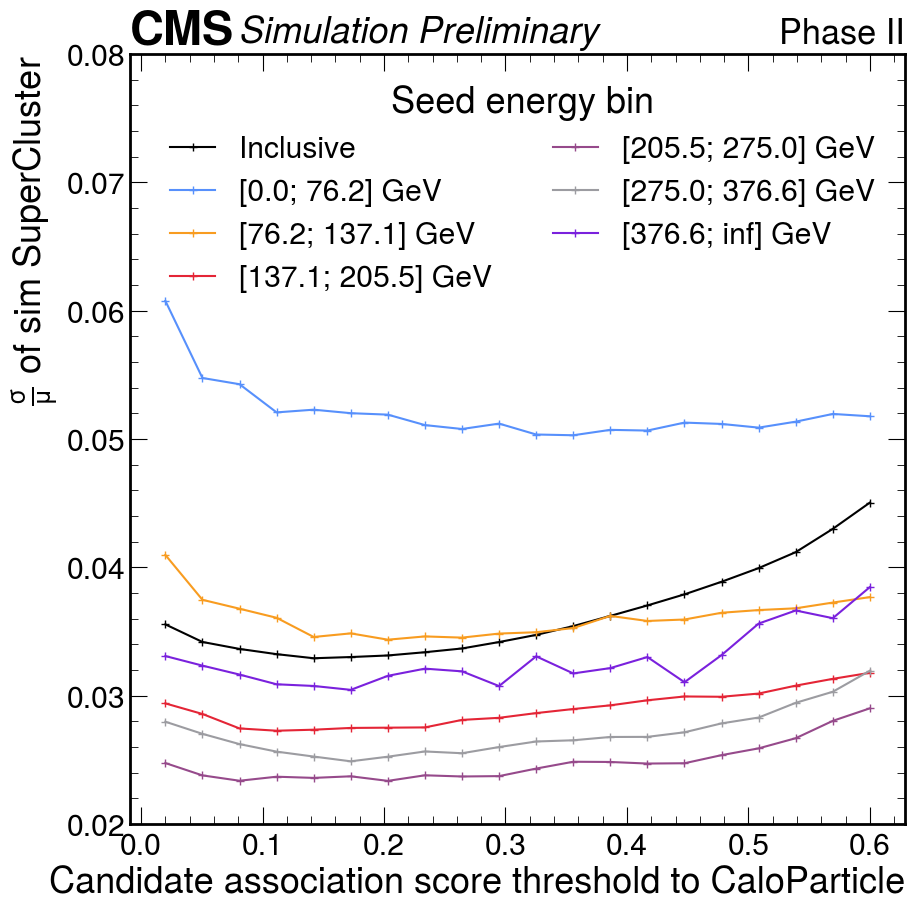

In [27]:
plt.plot(assocWps, sigmaOverMus_inclusive, "+-", label="Inclusive", color="black")
for b_ens in range(len(energy_bins)-1):
    plt.plot(assocWps, sigmaOverMus_perEnergy[b_ens], "+-", label="" + '[%.1f; %.1f] GeV' %(energy_bins[b_ens], energy_bins[b_ens+1]))
plt.xlabel("Candidate association score threshold to CaloParticle")
plt.ylabel(r"$\frac{\sigma}{\mu}$ of sim SuperCluster")
plt.legend(title="Seed energy bin", ncol=2)
plt.ylim(0.02, 0.08)
hep.cms.label("Preliminary", rlabel="Phase II")

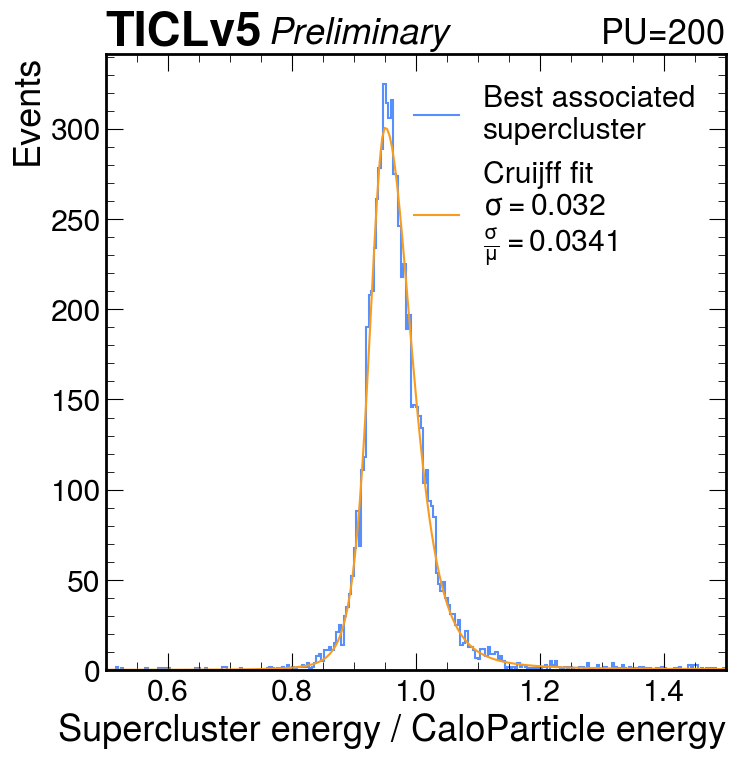

In [64]:
h, fitRes = fitRatio(0.6)
plotSingleHistWithFit(h, fitRes)

/grid_mnt/vol_home/llr/cms/cuisset/hgcal/supercls/repoForJobs/dnn_training/../analyzer/energy_resolution/fit.py:46: RuntimeWarning: overflow encountered in exp
  return A* np.exp(-dx*dx/f)


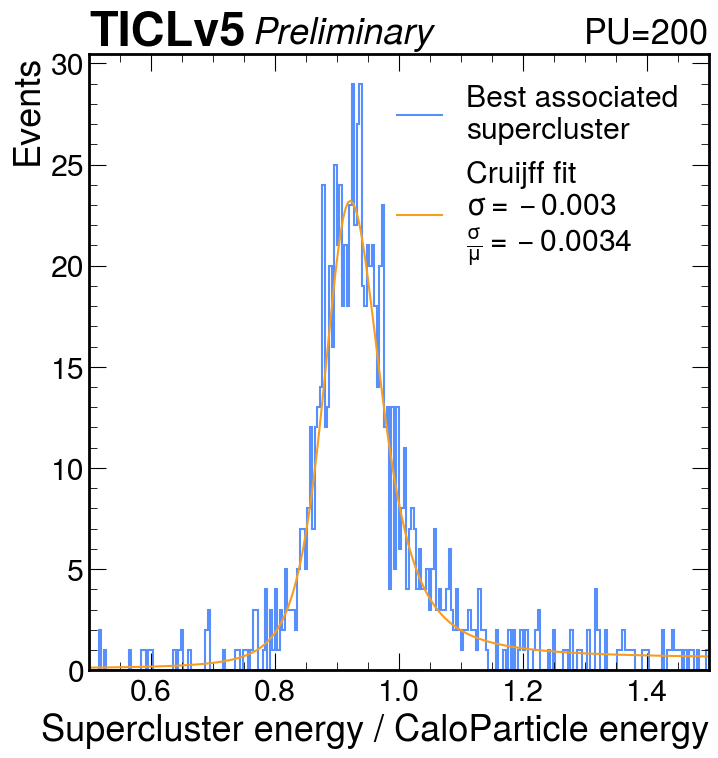

In [218]:
b_ens=0
sel = (val_dataset["seedEnergy_perEvent"]>energy_bins[b_ens]) & (val_dataset["seedEnergy_perEvent"]<energy_bins[b_ens+1])
h, fitRes = fitRatio(0.2, sel)
plotSingleHistWithFit(h, fitRes)

In [227]:
q_min2, q_min1, median, q_plus1, q_plus2

(0.764,
 0.8769894736842105,
 0.9425405405405405,
 1.105466666666667,
 1.8126666666666666)

In [225]:
median-q_min1, q_plus1-median

(0.06555106685632994, 0.16292612612612656)

In [228]:
h_forFit = h
from scipy.optimize import curve_fit
mean = np.average(h_forFit.axes[0].centers, weights=h_forFit.values())
q_min2, q_min1, median, q_plus1, q_plus2 = histogram_quantiles(h_forFit, [0.5-0.95/2, 0.5-0.68/2, 0.5, 0.5+0.68/2, 0.5+0.95/2])
p0 = [np.max(h_forFit)*0.8, mean, median-q_min1, q_plus1-median,  (q_min1-q_min2) / (median-q_min1)/3.81 * 0.28067382, (q_plus2-q_plus1) / (q_plus1-median)/3.81 * 0.28067382]
param_optimised,param_covariance_matrix = curve_fit(cruijff, h_forFit.axes[0].centers, h_forFit.values(), 
    p0=p0, sigma=np.maximum(np.sqrt(h_forFit.values()), 1.8), absolute_sigma=True, maxfev=500000,
    #bounds=np.transpose([(0., np.inf), (-np.inf, np.inf), (0., np.inf), (0., np.inf), (-np.inf, np.inf), (-np.inf, np.inf)])
    )
p0

[23.200000000000003,
 1.0170549019607844,
 0.06555106685632994,
 0.16292612612612656,
 0.12697994983077915,
 0.319763177100915]

In [220]:
param_optimised

array([23.20798743,  0.921254  ,  0.04025879, -0.04650919,  0.17451841,
        0.27049356])

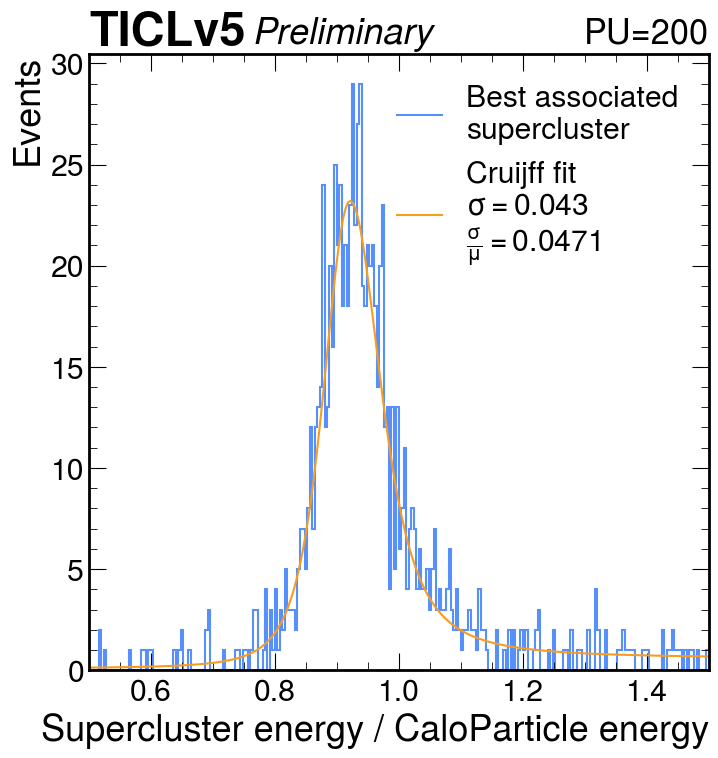

In [229]:
plotSingleHistWithFit(h, CruijffFitResult(CruijffParam(*param_optimised), param_covariance_matrix))

In [230]:
from iminuit import Minuit
from iminuit.cost import LeastSquares